In [27]:
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from efficientnet_pytorch import EfficientNet
from torchvision.models import densenet121, vgg16, inception_v3

In [28]:
import os
import pickle
from PIL import Image
import numpy as np
from collections import Counter
from sklearn.preprocessing import StandardScaler, LabelEncoder


In [29]:
# Load y_train
with open('y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)

# Load y_test
with open('y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

# Load flattened features from the second pickle file
with open('flattened_vgg16.pkl', 'rb') as file:
    X_train_extracted1 = pickle.load(file)

# Load flattened features from the second pickle file
with open('flattened_vgg16_testing.pkl', 'rb') as file:
    X_test_extracted1 = pickle.load(file)

# Load flattened features from the second pickle file
with open('flattened_efficientnetb2.pkl', 'rb') as file:
    X_train_extracted2 = pickle.load(file)

# Load flattened features from the second pickle file
with open('flattened_efficientnetb2_testing.pkl', 'rb') as file:
    X_test_extracted2 = pickle.load(file)

X_train_extracted = np.concatenate((X_train_extracted1, X_train_extracted2), axis=1)
X_test_extracted = np.concatenate((X_test_extracted1, X_test_extracted2), axis=1)


In [30]:
num_classes = 12

In [31]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [32]:
import torch
from sklearn.preprocessing import StandardScaler

# Assuming X_train_extracted and X_test_extracted are NumPy arrays

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform on training data, then transform test data
X_train_scaled = scaler.fit_transform(X_train_extracted)
X_test_scaled = scaler.transform(X_test_extracted)

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np


class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Assuming X_train_extracted, y_train are already defined
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_tensor, y_train_tensor, test_size=0.4, random_state=42)



# Create custom datasets and data loaders
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test_tensor, y_test_tensor)


train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)



In [34]:
X_train.shape

torch.Size([1144, 26496])

In [47]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(26496 // 4 * 64, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.7)  # Dropout with 50% probability
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.view(-1, 1, x.shape[1])  # Reshape to (batch_size, channels, sequence_length)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [48]:
model = SimpleCNN(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [49]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


SimpleCNN(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=423936, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.7, inplace=False)
  (fc2): Linear(in_features=128, out_features=12, bias=True)
)

In [50]:
# Training the model
num_epochs = 10

best_validation_accuracy = 0.0  # Track the best validation accuracy

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted_train = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted_train.eq(labels).sum().item()

    # Calculate training accuracy
    accuracy_train = correct_train / total_train

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, predicted_val = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted_val.eq(labels).sum().item()

        # Calculate validation accuracy
        accuracy_val = correct_val / total_val

        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_loss / len(train_loader):.4f}, '
              f'Training Accuracy: {accuracy_train:.4f}, '
              f'Validation Loss: {val_loss / len(val_loader):.4f}, '
              f'Validation Accuracy: {accuracy_val:.4f}')

        # Save the model with the best validation accuracy
        if accuracy_val > best_validation_accuracy:
            best_validation_accuracy = accuracy_val
            torch.save(model.state_dict(), 'best_model.pt')

# Load the best model
model.load_state_dict(torch.load('best_model.pt'))

# Evaluate the model on the testing set
model.eval()
with torch.no_grad():
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = model(inputs)
        test_loss += criterion(outputs, labels).item()
        _, predicted_test = outputs.max(1)
        total_test += labels.size(0)
        correct_test += predicted_test.eq(labels).sum().item()

    accuracy_test = correct_test / total_test

    print(f'Accuracy on Testing Set: {accuracy_test:.4f}')


Epoch [1/10], Training Loss: 1.9328, Training Accuracy: 0.4056, Validation Loss: 1.7822, Validation Accuracy: 0.7173
Epoch [2/10], Training Loss: 1.2844, Training Accuracy: 0.7220, Validation Loss: 1.9494, Validation Accuracy: 0.5694
Epoch [3/10], Training Loss: 0.7672, Training Accuracy: 0.9213, Validation Loss: 1.0228, Validation Accuracy: 0.9490
Epoch [4/10], Training Loss: 0.5144, Training Accuracy: 0.9528, Validation Loss: 0.4895, Validation Accuracy: 0.9817
Epoch [5/10], Training Loss: 0.3437, Training Accuracy: 0.9843, Validation Loss: 0.3492, Validation Accuracy: 0.9869
Epoch [6/10], Training Loss: 0.2390, Training Accuracy: 0.9904, Validation Loss: 0.2879, Validation Accuracy: 0.9895
Epoch [7/10], Training Loss: 0.1957, Training Accuracy: 0.9930, Validation Loss: 0.2113, Validation Accuracy: 0.9948
Epoch [8/10], Training Loss: 0.1629, Training Accuracy: 0.9965, Validation Loss: 0.1672, Validation Accuracy: 0.9974
Epoch [9/10], Training Loss: 0.1310, Training Accuracy: 0.9974, 

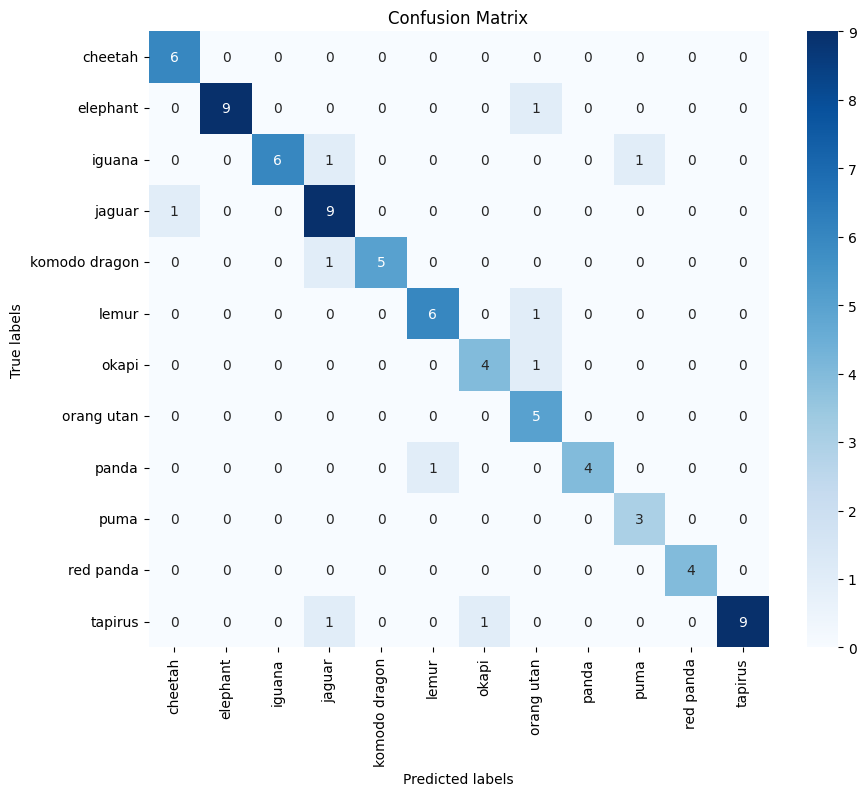

In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Evaluate the model on the testing set
model.eval()
predicted_labels = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [52]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(true_labels, predicted_labels, target_names=le.classes_, digits=4))


               precision    recall  f1-score   support

      cheetah     0.8571    1.0000    0.9231         6
     elephant     1.0000    0.9000    0.9474        10
       iguana     1.0000    0.7500    0.8571         8
       jaguar     0.7500    0.9000    0.8182        10
komodo dragon     1.0000    0.8333    0.9091         6
        lemur     0.8571    0.8571    0.8571         7
        okapi     0.8000    0.8000    0.8000         5
   orang utan     0.6250    1.0000    0.7692         5
        panda     1.0000    0.8000    0.8889         5
         puma     0.7500    1.0000    0.8571         3
    red panda     1.0000    1.0000    1.0000         4
      tapirus     1.0000    0.8182    0.9000        11

     accuracy                         0.8750        80
    macro avg     0.8866    0.8882    0.8773        80
 weighted avg     0.9002    0.8750    0.8783        80

